In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn as nn
import torch.nn.functional as F

In [2]:
plt.ion()

# Load data
csv_data = pd.read_csv("dataSet_withFeatures.csv", header=None)
csv_labels = pd.read_csv("dataSet_withFeatures_labels.csv", header=None)
labels = np.asarray(csv_labels, dtype=str).reshape(-1,1)
inputs = np.asarray(csv_data.iloc[:,:-1], dtype=float)

print(inputs.shape)

# Remap labels
labels_dict = {'asphalt': 0, 'cork':1, 'grass': 2, 'gravel':3, 'lab':4, 'laminate_wood': 5, 'pebble': 6, 'sand': 7}
int_labels = np.zeros((labels.shape[0],))
for i in range(len(labels)):
  int_labels[i] = labels_dict[labels[i][0]]

# Shuffle
# new_indexes = np.random.permutation(len(inputs))
# inputs = inputs[new_indexes]
# int_labels = int_labels[new_indexes]

'''Split data'''
# Train/Temp split (stratified)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, temp_index in sss1.split(inputs, int_labels):
    X_train, X_temp = inputs[train_index], inputs[temp_index]
    y_train, y_temp = int_labels[train_index], int_labels[temp_index]

# Validation/Test split (stratified)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_index, test_index in sss2.split(X_temp, y_temp):
    X_val, X_test = X_temp[val_index], X_temp[test_index]
    y_val, y_test = y_temp[val_index], y_temp[test_index]

'''Normalize data'''
# First normalize the raw data channels
n_train,_ = np.shape(X_train)
n_eval,_ = np.shape(X_val)
n_test,_ = np.shape(X_test)

X_train_n = X_train[:,0:414].reshape([n_train,6,69])
X_val_n = X_val[:,0:414].reshape([n_eval,6,69])
X_test_n = X_test[:,0:414].reshape([n_test,6,69])

for i in range(6):
  channel_mean = np.mean(X_train_n[:,i,:])
  channel_std = np.std(X_train_n[:,i,:])

  X_train_n[:,i,:] = (X_train_n[:,i,:] - channel_mean)/channel_std
  X_val_n[:,i,:] = (X_val_n[:,i,:] - channel_mean)/channel_std
  X_test_n[:,i,:] = (X_test_n[:,i,:] - channel_mean)/channel_std

# reshape
X_train[:,0:414] = X_train_n.reshape([n_train, 414])
X_val[:,0:414] = X_val_n.reshape([n_eval, 414])
X_test[:,0:414] = X_test_n.reshape([n_test, 414])

# Next normalize the custom features
for i in range(33):
    f_i = X_train[:,(414+i)]
    f_i_mean = np.mean(f_i)
    f_i_std = np.std(f_i)
    if f_i_std == 0.0:
        print(i)
        X_train[:,(414+i)] = (X_train[:,(414+i)] - f_i_mean)
        X_val[:,(414+i)] = (X_val[:,(414+i)] - f_i_mean)
        X_test[:,(414+i)] = (X_test[:,(414+i)] - f_i_mean)
    else:
        X_train[:,(414+i)] = (X_train[:,(414+i)] - f_i_mean)/f_i_std
        X_val[:,(414+i)] = (X_val[:,(414+i)] - f_i_mean)/f_i_std
        X_test[:,(414+i)] = (X_test[:,(414+i)] - f_i_mean)/f_i_std

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5990, 447)
(4193, 447)
(898, 447)
(899, 447)


In [3]:
class SensorDataset(Dataset):
  def __init__(self, inputs, labels, transform=None):
    self.inputs = inputs
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    input = self.inputs[idx,0:414]
    features = self.inputs[idx,414:447]
    label = self.labels[idx]

    if self.transform:
      input = self.transform(input)

    input = torch.from_numpy(input).float()
    features = torch.from_numpy(features).float()
    label = torch.tensor(label).long().squeeze()
    sample = {'sensor_data': input, 'features': features,'terrain': label}

    return sample

def reshape_transform(input):
  return input.reshape(6,1,69) # from (1,414)

# sensor_dataset = SensorDataset(inputs,int_labels,transform = reshape_transform)
# for i, sample in enumerate(sensor_dataset):
#   print(i, sample['sensor_data'].shape, sample['terrain'])
#     if i == 3:
#     break

# print(len(sensor_dataset))

In [4]:
train_dataset = SensorDataset(X_train, y_train, transform = reshape_transform)
val_dataset = SensorDataset(X_val, y_val, transform = reshape_transform)
test_dataset = SensorDataset(X_test, y_test, transform = reshape_transform)

batch_size = 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
class TerrainNet(nn.Module):
  def __init__(self):
    super(TerrainNet, self).__init__()

    self.conv1 = nn.Conv2d(6,24,kernel_size=(1,5), stride = 1, padding = (0,1))
    self.conv2 = nn.Conv2d(24,24,kernel_size=(1,5), stride = 1, padding = (0,1))
    self.conv3 = nn.Conv2d(24,24,kernel_size=(1,5), stride = 1, padding = (0,1))
    self.conv4 = nn.Conv2d(24,24,kernel_size=(1,5), stride = 1, padding = (0,1))
    self.lin1 = nn.Linear(1368+3,50) # 1368 = 24*57
    self.lin2 = nn.Linear(50,8)
    self.dropout = nn.Dropout(p=0.5)
    self.pool = nn.MaxPool2d((1,2), stride = 1)

  def forward(self, x, f):
    x.view(x.size(0), -1)
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = self.dropout(x)

    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = self.dropout(x)

    x = F.relu(self.conv3(x))
    x = self.pool(x)
    x = self.dropout(x)

    x = F.relu(self.conv4(x))
    x = self.pool(x)
    x = self.dropout(x)
    x = x.view(x.size(0), -1)

    x = torch.cat((x,f[:,[2,3,5]]), dim=1)

    x = F.relu(self.lin1(x))
    # x = self.dropout(x)
    x = self.lin2(x)

    return x

class TerrainLSTMNet(nn.Module):
    def __init__(self, input_size=6, hidden_size=36, num_layers=3, num_classes=8):
        super(TerrainLSTMNet, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=0.5,
            batch_first=True,
            bidirectional=False
        )

        self.fc1 = nn.Linear(hidden_size * 69 + 3, 70)
        self.fc2 = nn.Linear(70, num_classes)

    def forward(self, x, f):
        # x: (batch_size, 6, 1, 69)
        x = x.squeeze(2).permute(0, 2, 1)  # (batch_size, 69, 6)

        x, _ = self.lstm(x)        # (batch_size, 69, hidden_size)

        # (batch_size, 69 * hidden_size)
        x = x.reshape(x.size(0), -1)

        x = torch.cat((x,f[:,[2,3,5]]), dim=1)

        x = F.tanh(self.fc1(x))  # (batch_size, 70)
        x = F.tanh(self.fc2(x))
        return x

class TerrainGRUNet(nn.Module):
    def __init__(self, input_size=6, hidden_size=36, num_layers=3, num_classes=8):
        super(TerrainGRUNet, self).__init__()

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=0.5,
            batch_first=True,
        )

        self.fc1 = nn.Linear(hidden_size * 69 + 3, 70)
        self.fc2 = nn.Linear(70, num_classes)

    def forward(self, x, f):
        # x: (batch_size, 6, 1, 69)
        x = x.squeeze(2).permute(0, 2, 1)  # (batch_size, 69, 6)

        x, _ = self.gru(x)        # (batch_size, 69, hidden_size)

        # (batch_size, 69 * hidden_size)
        x = x.reshape(x.size(0), -1)

        x = torch.cat((x,f[:,[2,3,5]]), dim=1)

        x = F.tanh(self.fc1(x))  # (batch_size, 70)
        x = F.tanh(self.fc2(x))
        return x

In [10]:
def weights_init(m):
  if isinstance(m, nn.Conv2d):
    nn.init.xavier_uniform_(m.weight.data)

def weights_reset(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    m.reset_parameters()

terrain_net = TerrainGRUNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
terrain_net.to(device)
terrain_net.apply(weights_init)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(terrain_net.parameters(), lr=0.0001, weight_decay=1e-5)

model_path = './best_val_model'

cuda


In [11]:
def train_net(data_loader, model, loss_fn, optimizer, batch_size):
  terrain_net.train()
  size = len(data_loader.dataset)
  for i,data in enumerate(train_loader,0): # data contains 16 samples, so i counts the number of mini-batches

    inputs = data['sensor_data'].to(device)
    features = data['features'].to(device)
    labels = data['terrain'].to(device)

    optimizer.zero_grad()

    outputs = terrain_net(inputs, features)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    if i % 2000 == 0:
        loss, current = loss.item(), i * batch_size + len(inputs)
        # print(len(inputs))
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def eval_net(data_loader, model, loss_fn, model_path, best_acc):
  terrain_net.eval()
  size = len(data_loader.dataset)
  n_batches = len(data_loader)

  # print(size)
  # print(n_batches)

  eval_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for data in data_loader:
      inputs = data['sensor_data'].to(device)
      features = data['features'].to(device)
      labels = data['terrain'].to(device)

      outputs = model(inputs,features)
      prediction = torch.argmax(outputs, dim=1)

      total += labels.size(0)
      correct += (prediction == labels).sum().item()

  acc = 100*correct/total
  print(f'accuracy: {acc:>0.3f}')
  if acc > best_acc:
      torch.save(model.state_dict(), model_path)
      best_acc = acc
      print(f'model saved with accuracy: {acc:>0.3f}')
  return best_acc
'''   pred = model(inputs)
      # print(pred)
      eval_loss += loss_fn(pred, labels).item()
      correct += (pred.argmax(dim=1) == labels).sum().item()

  eval_loss /= n_batches
  correct /= size
  print(f"Eval Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {eval_loss:>8f} \n")
'''
  # return eval_loss / n_batches, correct / len(data_loader.dataset)

'   pred = model(inputs)\n      # print(pred)\n      eval_loss += loss_fn(pred, labels).item()\n      correct += (pred.argmax(dim=1) == labels).sum().item()\n\n  eval_loss /= n_batches\n  correct /= size\n  print(f"Eval Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {eval_loss:>8f} \n")\n'

In [12]:
epochs = 150
acc = 0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_net(train_loader, terrain_net, criterion, optimizer, batch_size)
    acc = eval_net(val_loader, terrain_net, criterion, model_path, acc)
print("Done!")

Epoch 1
-------------------------------
loss: 2.187226  [    1/ 4193]
loss: 1.517197  [ 2001/ 4193]
loss: 1.229410  [ 4001/ 4193]
accuracy: 44.209
model saved with accuracy: 44.209
Epoch 2
-------------------------------
loss: 1.924907  [    1/ 4193]
loss: 1.322122  [ 2001/ 4193]
loss: 1.851063  [ 4001/ 4193]
accuracy: 46.882
model saved with accuracy: 46.882
Epoch 3
-------------------------------
loss: 2.205907  [    1/ 4193]
loss: 1.078933  [ 2001/ 4193]
loss: 1.305144  [ 4001/ 4193]
accuracy: 51.670
model saved with accuracy: 51.670
Epoch 4
-------------------------------
loss: 1.406996  [    1/ 4193]
loss: 1.432922  [ 2001/ 4193]
loss: 1.292702  [ 4001/ 4193]
accuracy: 46.771
Epoch 5
-------------------------------
loss: 0.979928  [    1/ 4193]
loss: 1.071933  [ 2001/ 4193]
loss: 1.234710  [ 4001/ 4193]
accuracy: 51.336
Epoch 6
-------------------------------
loss: 1.410840  [    1/ 4193]
loss: 1.219957  [ 2001/ 4193]
loss: 1.293721  [ 4001/ 4193]
accuracy: 53.675
model saved with

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

model = TerrainGRUNet()
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

test_preds = []
test_labels = []

with torch.no_grad():
    for data in test_loader:
      inputs = data['sensor_data'].to(device)
      features = data['features'].to(device)
      labels = data['terrain'].to(device)

      outputs = model(inputs,features)
      prediction = torch.argmax(outputs, dim=1)

      test_preds.extend(prediction.cpu().numpy())
      test_labels.extend(labels.cpu().numpy())

accuracy = np.mean(np.array(test_preds) == np.array(test_labels))
print(f"Test Accuracy: {accuracy:.2%}")

Test Accuracy: 72.64%


['asphalt', 'cork', 'grass', 'gravel', 'lab', 'laminate_wood', 'pebble', 'sand']


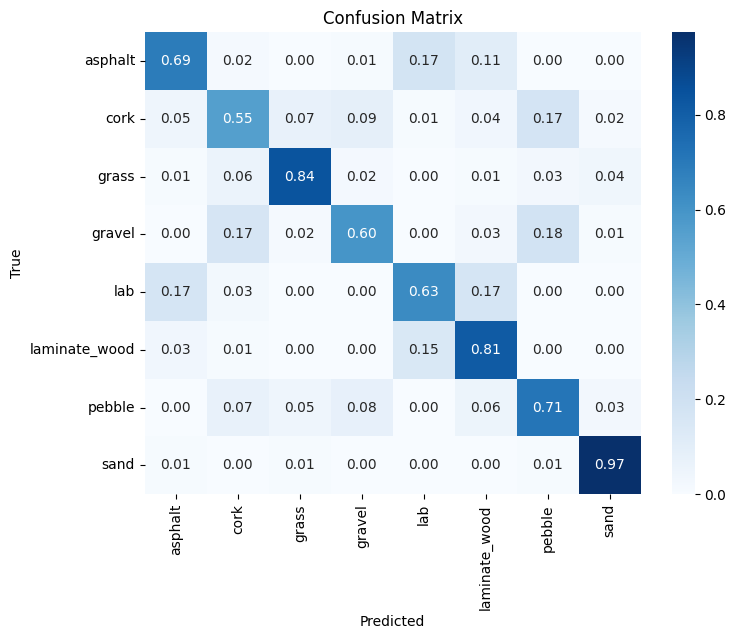

In [16]:
cm = confusion_matrix(test_labels, test_preds, normalize='true')
plt.figure(figsize=(8, 6))
class_names=[f"{i}" for i in labels_dict]
print(class_names)
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()